In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator,TransformerMixin
import os

In [2]:
class Data:
    
    def __init__(self,train_path,test_path,cible_path,header_path,sep): 
        
        import pandas as pd
    
        self.train_path=train_path
        self.test_path=test_path
        self.cible_path=cible_path
        self.header_path=header_path
        self.sep=sep
        self.train=pd.read_table(self.train_path, sep=self.sep,header=None)
        self.test=pd.read_table(self.test_path, sep=self.sep,header=None)
        self.cible=pd.read_table(self.cible_path,sep=self.sep,header=None)
        self.header=pd.read_csv(self.header_path,sep=self.sep,header=None)
               
    @property
    def test_path(self):
        return self._test_path

    @test_path.setter
    def test_path(self, v):
        self._test_path  =  v 
        
    @property
    def train_path(self):
        return self._train_path

    @train_path.setter
    def train_path(self, v):
        self._train_path  =  v 
        
    @property
    def train(self):
        return self._train

    @train.setter
    def train(self, v):
        self._train  =  v
        
    @property
    def alldata(self):
        return self._alldata

    @alldata.setter
    def alldata(self, v):
        self._alldata  =  v 
        
    @property
    def header(self):
        return self._header

    @header.setter
    def header(self, v):
        self._header  =  v
        
    @property
    def cible(self):
        return self._cible

    @cible.setter
    def cible(self, v):
        self._cible  =  v 
                
    @property
    def sep(self):
        return self._sep

    @sep.setter
    def sep(self, v):
        self._sep  =  v 
        
    @property
    def feature_name(self):
        return self._feature_name

    @feature_name.setter
    def feature_name(self, v):
        self._feature_name  =  v 
    
    # Create a the list of features name based on the header
    def createFeaturesName(self,indexToRemove,colToRemove,name='xForm'):
        self.feature_name=self.header.drop(self.header.columns[colToRemove], axis=1)
        if name=='xForm':    
            self.feature_name=self.feature_name.drop(self.feature_name.index[indexToRemove])[1]
        else:
            self.feature_name=self.feature_name.drop(self.feature_name.index[indexToRemove])[3]

    # Put headers to the data      
    def nameData(self):
        self.train.columns=self.feature_name
        self.test.columns=self.feature_name
        
        return self
        
    # Put Train/Test together     
    def joinData(self):
        
        import pandas as pd

        frames=[self.train,self.test]
        self.alldata= pd.concat(frames,keys=['train','test'])
        
        return self

    # Sous fonction à généralier..
    def oneHot(self,on='all'):
        if on=='all':
            self.alldata['x51']=self.alldata['x51']-2011
        
        return self
    
    
    def takeTrain(self):
    
        return self.alldata.ix['train']
 
 
    def takeTest(self):
    
        return self.alldata.ix['test']

In [3]:
class CreateAllData(TransformerMixin):
    
    """ Add the test to train """

    def __init__(self,testSet):
        self.testSet=testSet
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        
        import pandas as pd

        frames=[X,self.testSet]
        alldata= pd.concat(frames,keys=['train','test'])
             
        return alldata
    
    def get_params(self, deep=True):
        return {"testSet": self.testSet}

    def set_params(self, **parameters):
        self.testSet = parameters["testSet"]
        return self
    

In [4]:
class Drop(TransformerMixin):
    
    """ Scale data"""

    def __init__(self,colsToDrop):
        self.colsToDrop=colsToDrop
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        
        alldata_scale=X.drop(X[self.colsToDrop], axis=1)
             
        return alldata_scale
    
    def get_params(self, deep=True):
        return {"colsToDrop": self.colsToDrop}

    def set_params(self, **parameters):
        self.colsToDrop = parameters["colsToDrop"]
        return self
    

In [5]:
class Scale(TransformerMixin):
    
    """ Scale data à faire évoluer : ne scaler que les 2012, et pas scaler la colonne 51"""
    
    def __init__(self,methode,typeScaling):
        self.methode=methode
        self.typeScaling=typeScaling

    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        # Ca ne scale pas la colonne year et ça ne scale que l'année 2012
        scaleX=X
        index2012=np.where(X['x51']==1)
        
        if self.typeScaling=='normalized':
        
            if self.methode=='2012':
                for j in range(len(X.columns)-1):
                    scaleX.iloc[:,j][index2012[0]]=(X.iloc[:,j][index2012[0]]-X.iloc[:,j][index2012[0]].mean())/X.iloc[:,j][index2012[0]].var()
        
            if self.methode=='all':
                for j in range(len(X.columns)-1):
                    scaleX.iloc[:,j]=(X.iloc[:,j]-X.iloc[:,j].mean())/X.iloc[:,j].var()
                
            if self.methode=='noScale':
                  scaleX=X
                    
        if self.typeScaling=='minmax':
            
            if self.methode=='2012':
                for j in range(len(X.columns)-1):
                    scaleX.iloc[:,j][index2012[0]]=(X.iloc[:,j][index2012[0]]-X.iloc[:,j][index2012[0]].min())/(X.iloc[:,j][index2012[0]].max()-X.iloc[:,j][index2012[0]].min())
        
            if self.methode=='all':
                for j in range(len(X.columns)-1):
                    scaleX.iloc[:,j]=(X.iloc[:,j]-X.iloc[:,j].min())/(X.iloc[:,j].max()-X.iloc[:,j].min())
                
            if self.methode=='noScale':
                  scaleX=X
            
             
        return scaleX
    
    def get_params(self, deep=True):
        return {"methode": self.methode,"typeScaling":typeScaling}

    def set_params(self, **parameters):
        self.methode = parameters["name"]
        self.typeScaling = parameters["typeScaling"]
        return self
    

In [6]:
class FillNaN_KNN(TransformerMixin):
    
    """ Fill Nan is data using KNN implementation of fancyimpute"""
    
    def __init__(self,k):
        self.k=k

    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        from fancyimpute import KNN
        
        alldata_filled = KNN(k=self.k,verbose=False).complete(X)
                
        return alldata_filled
        
    def get_params(self, deep=True):
        return {"k": self.k}

    def set_params(self, **parameters):
        self.k = parameters["k"]
        return self

In [7]:
class RebuildDF(TransformerMixin):
    
    """Rebuild from an ndarray a Dataframe with the original index"""
    
    def __init__(self,dataInit,colsToAdd):
        self.dataInit=dataInit
        self.colsToAdd=colsToAdd

    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        import pandas as pd
        
        datacomplete=pd.DataFrame(X)
        #datacomplete.index=self.dataInit.index
        #datacomplete[self.colsToAdd]=self.dataInit[self.colsToAdd]
        #datacomplete.columns=self.dataInit.columns

        
        return datacomplete
    
    def get_params(self, deep=True):
        return {"dataInit": self.dataInit,"colsToAdd": self.colsToAdd}

    def set_params(self, **parameters):
        self.dataInit = parameters["dataInit"]
        self.colsToAdd = parameters["colsToAdd"]
        return self
    

In [8]:
class Take_train(TransformerMixin):
    
    """Rebuild from an ndarray a Dataframe with the original index"""
    
    def __init__(self,name):
        self.name=name
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        import numpy as np
        train=X.ix['train']
                
        return train
    
    def get_params(self, deep=True):
        return {"name": self.name}

    def set_params(self, **parameters):
        self.name = parameters["name"]
        return self
    

# Test


In [27]:
data=Data(train_path="../Data_competition/X_train.txt"
                      ,test_path="../Data_competition/X_test.txt"
                      ,cible_path="../Data_competition/y_train.txt"
                      ,header_path="../Data_competition/header.csv"
                      ,sep=',')

data.createFeaturesName(colToRemove=[2],indexToRemove=[56,49,30,20,14,0,38],name='xForm')
data.nameData().joinData().oneHot()

In [28]:
dir_path='../'
result_file='result_grid_10000.csv'
import os

In [29]:
text_file = open(os.path.join(dir_path, result_file), 'w')
for k in range(6,12):
    for typeScaling in ['minmax','normalized'] :
        for methode in ['2012','all','noScale'] :

            pipeline=Pipeline([ ('scale',Scale(methode=methode,typeScaling=typeScaling))
                   ,('knn', FillNaN_KNN(k=k))
                   ,('rebuildDF',RebuildDF(data.alldata,['x51']))
                    ])


            tuned_parameters = [{'loss': ['deviance'],
                    'max_features':[5],
                    'max_depth':[5],
                    'n_estimators':[1500]}]


            clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=10,verbose=1)
            clf.fit(pipeline.transform(data.takeTrain()),data.cible[0].values)
       
    
            print('--------------------------', file=text_file)
            print("KNN :"+str(k), file=text_file)
            print("methode :"+ methode, file=text_file)
            print("Scaling :"+ typeScaling, file=text_file)

            print('', file=text_file)
            print("Best parameters set found on development set:", file=text_file)
            print('', file=text_file)
            print(clf.best_params_, file=text_file)
            print('', file=text_file)

            print("Grid scores on development set:", file=text_file)
            print('', file=text_file)
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                    % (mean, std * 2, params), file=text_file)
            print('', file=text_file)
        
text_file.close()

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   32.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   30.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   30.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.6s finished


# Submission

In [254]:
data=Data(train_path="../Data_competition/X_train.txt"
                      ,test_path="../Data_competition/X_test.txt"
                      ,cible_path="../Data_competition/y_train.txt"
                      ,header_path="../Data_competition/header.csv"
                      ,sep=',')

data.createFeaturesName(colToRemove=[2],indexToRemove=[56,49,30,20,14,0,38],name='xForm')
data.nameData().joinData().oneHot()

In [255]:
pipeline=Pipeline([ ('scale',Scale('noScale'))
                   ,('knn', FillNaN_KNN(k=10))
                   ,('rebuildDF',RebuildDF(data.alldata,['x51']))
                    ])

In [256]:
clf = GradientBoostingClassifier(max_features=10,max_depth=3,n_estimators=500,loss='deviance')
clf.fit(pipeline.transform(data.takeTrain()),data.cible[0].values)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=10, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [257]:
y_pred_clf=clf.predict(pipeline.transform(data.takeTest()))

index=range(len(y_pred_clf))
data=np.transpose([index,y_pred_clf])
a = pd.DataFrame(data=data,columns=['Id','Prediction'])
a.to_csv("submission12.csv", sep=",",index=False)

# KNN on all and take the train test from all

In [258]:
data=Data(train_path="../Data_competition/X_train.txt"
                      ,test_path="../Data_competition/X_test.txt"
                      ,cible_path="../Data_competition/y_train.txt"
                      ,header_path="../Data_competition/header.csv"
                      ,sep=',')

data.createFeaturesName(colToRemove=[2],indexToRemove=[56,49,30,20,14,0,38],name='xForm')
data.nameData().joinData().oneHot()

In [245]:
pipeline=Pipeline([ ('scale',Scale(methode))
                   ,('knn', FillNaN_KNN(k=k))
                   ,('rebuildDF',RebuildDF(data.alldata,['x51']))
                    ])

In [247]:
X=pipeline.transform(data.alldata)
X.index=data.alldata.index

In [248]:
train=X.ix['train']
test=X.ix['test']

0         1         2         3         4         5         6   \
train 0  0.491722  1.264287 -0.158577 -0.150768  1.087627  0.157166 -1.053879   
      1 -0.249351  0.046088 -0.040435  0.105421 -1.098919  0.289237 -0.338154   
      2  0.986824 -0.189678  0.059693  0.010147  0.777260 -1.051633 -1.011747   
      3 -0.265990 -0.517960 -0.114526 -0.073818  1.889234 -0.161217 -0.947844   
      4  0.199900 -0.095447  0.263825  0.040790 -1.125166 -1.318912 -0.887661   

               7         8         9  ...         41        42        43  \
train 0 -1.116961 -0.145423  0.353896 ...  -0.046952 -0.599092 -0.582634   
      1  0.129297  0.807200 -0.596851 ...   0.468655  0.021401  0.527339   
      2 -0.756690 -0.592777  0.874877 ...  -0.271227 -0.095384  0.995816   
      3 -0.650268 -0.712451  1.073358 ...  -0.049093 -0.378151  0.121491   
      4 -1.202686 -0.228905 -0.379957 ...  -0.568337 -0.180425  0.397132   

               44        45        46        47        48        49   50  
train 0  0.342332  0.967435  5.284473  0.409764 -0.430782 -0.797375  0.0  
      1 -0.291376  0.072317  0.700883  0.922003  0.709037  0.237620  0.0  
      2  0.004617  0.480180 -0.244837 -0.105363 -0.447816 -0.386229  0.0  
      3 -0.268029  0.582835 -0.267091  0.408911 -0.755457 -0.526293  0.0  
      4 -0.357907 -0.798888 -0.336643  0.058582  0.033230 -0.535741  0.0  

[5 rows x 51 columns]

In [260]:
dir_path='../'
result_file='result_grid_5.csv'

In [261]:
text_file = open(os.path.join(dir_path, result_file), 'w')
for k in range(7,14):
    for typeScaling in ['minmax','normalized'] :
        for methode in ['2012','all','noScale'] :

            pipeline=Pipeline([ ('scale',Scale(methode))
                   ,('knn', FillNaN_KNN(k=k))
                   ,('rebuildDF',RebuildDF(data.alldata,['x51']))
                    ])

            X=pipeline.transform(data.alldata)
            X.index=data.alldata.index
            train=X.ix['train']
            test=X.ix['test']

        tuned_parameters = [{'loss': ['deviance'],
                    'max_features':[5,10,20],
                    'max_depth':[3,5,10],
                    'n_estimators':[100,300,500]}]


        clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=10,verbose=1)
        clf.fit(train,data.cible[0].values)
       
    
        print('--------------------------', file=text_file)
        print("KNN :"+str(k), file=text_file)
        print("methode :"+ methode, file=text_file)
        print('', file=text_file)
        print("Best parameters set found on development set:", file=text_file)
        print('', file=text_file)
        print(clf.best_params_, file=text_file)
        print('', file=text_file)

        print("Grid scores on development set:", file=text_file)
        print('', file=text_file)
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                    % (mean, std * 2, params), file=text_file)
        print('', file=text_file)
        
text_file.close()

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.4min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.5min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.5min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.4min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.4min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.3min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 16.5min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.3min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.3min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.4min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.3min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.3min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.3min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.3min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.3min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 10.0min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.4min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.4min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  7.2min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.5min finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.5min finished


In [262]:
pipeline=Pipeline([ ('scale',Scale('noScale'))
                   ,('knn', FillNaN_KNN(k=11))
                   ,('rebuildDF',RebuildDF(data.alldata,['x51']))
                    ])

X=pipeline.transform(data.alldata)
X.index=data.alldata.index
train=X.ix['train']
test=X.ix['test']


In [263]:
clf = GradientBoostingClassifier(max_features=5,max_depth=3,n_estimators=500,loss='deviance')
clf.fit(train,data.cible[0].values)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=5, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [264]:
y_pred_clf=clf.predict(test)

index=range(len(y_pred_clf))
data=np.transpose([index,y_pred_clf])
a = pd.DataFrame(data=data,columns=['Id','Prediction'])
a.to_csv("submission13.csv", sep=",",index=False)

# Neural Net to fill Nan

In [435]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [515]:
data=Data(train_path="../Data_competition/X_train.txt"
                      ,test_path="../Data_competition/X_test.txt"
                      ,cible_path="../Data_competition/y_train.txt"
                      ,header_path="../Data_competition/header.csv"
                      ,sep=',')

data.createFeaturesName(colToRemove=[2],indexToRemove=[56,49,30,20,14,0,38],name='xForm')
data.nameData().joinData().oneHot()

In [516]:
pipeline=Pipeline([('scale',Scale('all'))
                   ,('rebuildDF',RebuildDF(data.alldata,['x51']))])

In [517]:
X_train=pipeline.transform(data.takeTrain())
X_test=pipeline.transform(data.takeTest())

### Test sur quelques variables

In [518]:
train=X_train
test=X_test

In [498]:
x45_train=train['x49']
regressor_train=train[['x5','x6']]
x45_test=test['x49']
regressor_test=test[['x5','x6']]

In [499]:
regressor_fill_train=regressor_train[x45_train.notnull()]
regressor_fill_test=regressor_test[x45_test.notnull()]
x45_fill_train=x45_train[x45_train.notnull()]
x45_fill_test=x45_test[x45_test.notnull()]

regressor_na_train=regressor_train[x45_train.isnull()]
regressor_na_test=regressor_test[x45_test.isnull()]

In [500]:
mlp=MLPRegressor(hidden_layer_sizes=(3,),max_iter=500,activation='logistic')
mlp.fit(regressor_fill_train,x45_fill_train)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [501]:
predx45=mlp.predict(regressor_fill_test)

In [502]:
mse=np.mean((x45_fill_test.values-predx45)**2)

In [503]:
mse

0.13151682839306589

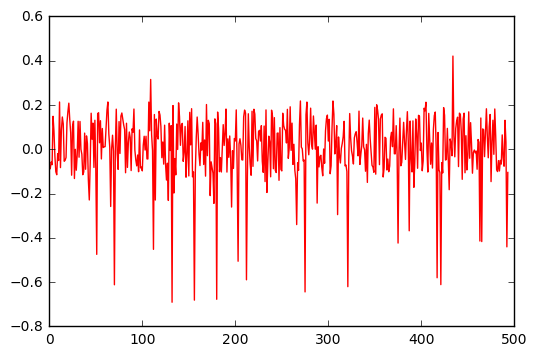

In [504]:
plt.plot(range(len(predx45)),predx45,'r-')
plt.show()

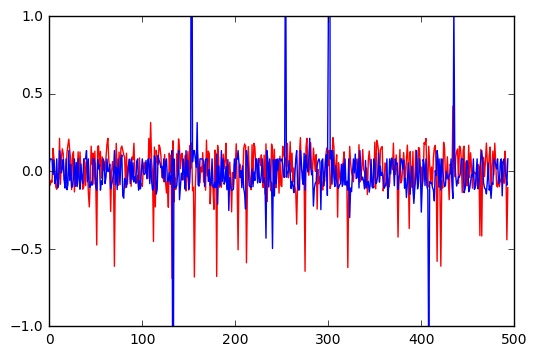

In [505]:
plt.plot(range(len(predx45)),predx45,'r-')
plt.plot(range(len(predx45)),x45_fill_test.values,'b-')
plt.ylim([-1,1])
plt.show()

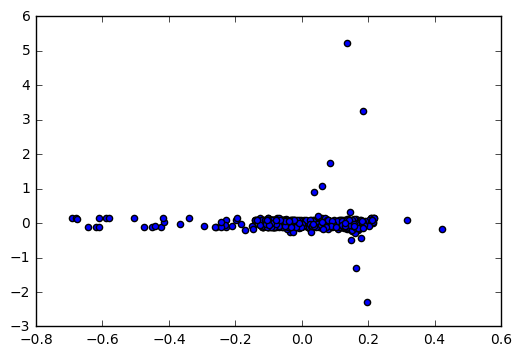

In [506]:
plt.scatter(predx45,x45_fill_test.values)
plt.show()

Ca ne marche pas très très bien pour l'instant.. Mais bon autant aller jusqu'au bout

In [507]:
pred_na_train=mlp.predict(regressor_na_train)
pred_na_test=mlp.predict(regressor_na_test)

In [508]:
x45_train[x45_train.isnull()]=pred_na_train
x45_test[x45_test.isnull()]=pred_na_test

In [512]:
list(set(['x'+str(j) for j in range(1,45)]).difference(['x'+str(j) for j in range(1,44)]))

['x44']

In [514]:
x45_test[x45_test.isnull()]

Series([], Name: x49, dtype: float64)

In [9]:
class FillNaN_MLP(TransformerMixin):
    
    """ Fill Nan is data using KNN implementation of fancyimpute"""
    
    def __init__(self,hidden_layer_sizes,regressor,maxiter):
        self.hidden_layer_sizes=hidden_layer_sizes
        self.regressor=regressor
        self.maxiter=maxiter

    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        
        from sklearn.neural_network import MLPRegressor
        
        X2=X
        regressor=X2[self.regressor]
        allfeatures=['x'+str(j) for j in range(1,51)]
        toRegress=list(set(allfeatures).difference(self.regressor))
        
        for col in toRegress:
            x=X[col]
            regressor_fill=regressor[x.notnull()]
            regressor_na=regressor[x.isnull()]
            x_fill=x[x.notnull()]
            
            mlp=MLPRegressor(hidden_layer_sizes=self.hidden_layer_sizes,max_iter=self.maxiter)
            mlp.fit(regressor_fill,x_fill)
            pred_na=mlp.predict(regressor_na)
            
            X2.loc[x.isnull(),col]=pred_na
            
        return X2
        
        
        
    def get_params(self, deep=True):
        return {"hidden_layer_sizes": self.hidden_layer_sizes,"regressor":self.regressor}

    def set_params(self, **parameters):
        self.hidden_layer_sizes = parameters["hidden_layer_sizes"]
        self.regressor = parameters["regressor"]
        return self

## Test

In [598]:
data=Data(train_path="../Data_competition/X_train.txt"
                      ,test_path="../Data_competition/X_test.txt"
                      ,cible_path="../Data_competition/y_train.txt"
                      ,header_path="../Data_competition/header.csv"
                      ,sep=',')

data.createFeaturesName(colToRemove=[2],indexToRemove=[56,49,30,20,14,0,38],name='xForm')
data.nameData().joinData().oneHot()

In [604]:
for k in [(1,),(2,),(3,2,)]:
    print(k)

(1,)
(2,)
(3, 2)


In [599]:
pipeline=Pipeline([ ('scale',Scale('noScale'))
                   ,('fill_MLP',
                         FillNaN_MLP(hidden_layer_sizes=(3,),
                                     regressor=['x'+str(j) for j in range(1,9)],
                                     maxiter=600))
                   ,('rebuildDF',RebuildDF(data.alldata,['x51']))
                    ])

In [600]:
X=pipeline.transform(data.alldata)

//anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [11]:
dir_path='../'
result_file='result_grid_MLP_3.csv'

In [14]:
text_file = open(os.path.join(dir_path, result_file), 'w')
#for k in range(2,5):
for k in [(2,),(3,),(4,),(3,2,),(4,3,)]:
    for methode in ['2012','all','noScale'] :
        for typeScaling in ['minmax','normalized'] :
        
        
            data=Data(train_path="../Data_competition/X_train.txt"
                          ,test_path="../Data_competition/X_test.txt"
                          ,cible_path="../Data_competition/y_train.txt"
                          ,header_path="../Data_competition/header.csv"
                          ,sep=',')

            data.createFeaturesName(colToRemove=[2],indexToRemove=[56,49,30,20,14,0,38],name='xForm')
            data.nameData().joinData().oneHot()

            pipeline=Pipeline([ ('scale',Scale(methode=methode,typeScaling=typeScaling))
                   ,('fill_MLP',
                         FillNaN_MLP(hidden_layer_sizes=k,
                                     regressor=['x'+str(j) for j in range(1,9)],
                                     maxiter=1500))
                   ,('rebuildDF',RebuildDF(data.alldata,['x51']))
                    ])

            X=pipeline.transform(data.alldata)
            X.index=data.alldata.index
            train=X.ix['train']
            test=X.ix['test']

            tuned_parameters = [{'loss': ['deviance'],
                    'max_features':[5,10,20],
                    'max_depth':[3,5,10],
                    'n_estimators':[20,50,80,100]}]


            clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=10,verbose=1)
            clf.fit(train,data.cible[0].values)
       
    
            print('--------------------------', file=text_file)
            print("KNN :"+str(k), file=text_file)
            print("methode :"+ methode, file=text_file)
            print('', file=text_file)
            print("Best parameters set found on development set:", file=text_file)
            print('', file=text_file)
            print(clf.best_params_, file=text_file)
            print('', file=text_file)

            print("Grid scores on development set:", file=text_file)
            print('', file=text_file)
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                        % (mean, std * 2, params), file=text_file)
            print('', file=text_file)
        
text_file.close()

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.2min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.0min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.3min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.1min finished
//anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.2min finished
//anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.1min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.2min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.2min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.4min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.3min finished
//anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


KeyboardInterrupt: 

## Test en séparant le test et le train

In [624]:
dir_path='../'
result_file='result_grid_MLP_filled_split_traintest.csv'

In [ ]:
text_file = open(os.path.join(dir_path, result_file), 'w')
for k in [(2,),(3,),(3,2,)]:
    for methode in ['2012','all','noScale'] :
        for typeScaling in ['minmax','normalized'] :
        
        
            data=Data(train_path="../Data_competition/X_train.txt"
                          ,test_path="../Data_competition/X_test.txt"
                          ,cible_path="../Data_competition/y_train.txt"
                          ,header_path="../Data_competition/header.csv"
                          ,sep=',')

            data.createFeaturesName(colToRemove=[2],indexToRemove=[56,49,30,20,14,0,38],name='xForm')
            data.nameData().joinData().oneHot()

            pipeline=Pipeline([ ('scale',Scale(methode=methode,typeScaling=typeScaling))
                   ,('fill_MLP',
                         FillNaN_MLP(hidden_layer_sizes=k,
                                     regressor=['x'+str(j) for j in range(1,9)],
                                     maxiter=1500))
                   ,('rebuildDF',RebuildDF(data.alldata,['x51']))
                    ])

            train=pipeline.transform(data.takeTrain())
  

            tuned_parameters = [{'loss': ['deviance'],
                    'max_features':[5,10],
                    'max_depth':[3,5],
                    'n_estimators':[500,700,1000,1500]}]


            clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=10,verbose=1)
            clf.fit(train,data.cible[0].values)
       
    
            print('--------------------------', file=text_file)
            print("KNN :"+str(k), file=text_file)
            print("methode :"+ methode, file=text_file)
            print('', file=text_file)
            print("Best parameters set found on development set:", file=text_file)
            print('', file=text_file)
            print(clf.best_params_, file=text_file)
            print('', file=text_file)

            print("Grid scores on development set:", file=text_file)
            print('', file=text_file)
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                        % (mean, std * 2, params), file=text_file)
            print('', file=text_file)
        
text_file.close()

Fitting 10 folds for each of 16 candidates, totalling 160 fits
